In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
# sys.path.append(os.path.abspath(os.path.join('../utils')))
sys.path.append('../')

import cv2
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from utils.datagenerator import EyeDataset, OpenEDS
from metrics import *
from utils.utils import load_image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras_fc_densenet import _create_fc_dense_net, build_FC_DenseNet10

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
# dynamically grow GPU memory
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))

%load_ext autoreload
%autoreload 2

2022-10-19 18:01:08.701791: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-10-19 18:01:08.724408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2022-10-19 18:01:08.724994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5651d8389ea0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-19 18:01:08.725022: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-19 18:01:08.735065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-19 18:01:08.788949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-1

In [2]:
def class_mean_iou(pred, label):
    pred = np.argmax(pred, axis=-1)
    label = np.argmax(label, axis=-1)
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels)

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    class_iou = []
    
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
        class_iou.append(np.mean(I[index] / U[index]))

    dict_class_iou = {
        'bg': class_iou[0],
        'iris': class_iou[2],
        'pupil': class_iou[3],
        'sclera': class_iou[1],
        'miou': np.mean(class_iou),
        'stdiou:': np.std(class_iou)
    }
    
    return dict_class_iou

def mIoU(pred, label, ths=0.5):
    num_unique_labels = label.shape[-1]

    I = np.zeros(num_unique_labels, dtype=np.float32)
    U = np.zeros(num_unique_labels, dtype=np.float32)
    class_iou = np.zeros(num_unique_labels, dtype=np.float32)
    
    for index in range(num_unique_labels):
        mask = np.where(pred[..., index] > ths, 1., 0.)
        
        I[index] = float(np.sum(np.logical_and(label[..., index], mask)))
        U[index] = float(np.sum(np.logical_or(label[..., index], mask)))
        iou = np.mean(I[index] / U[index])
        
        class_iou[index] = iou if not np.isnan(iou) else 0.0

    dict_class_iou = {
        'bg': class_iou[0],
        'iris': class_iou[2],
        'pupil': class_iou[3],
        'sclera': class_iou[1],
        'miou': np.mean(class_iou),
        'stdiou:': np.std(class_iou)
    }
    
    return dict_class_iou

In [3]:
dim = (320, 320)

# dataset contains pupil, iris, sclera and eye marks

# dataset_dir = "/home/choppy/TOC/datasets/alcohol/alcohol_v7.0"

dataset_dir = '/media/choppy/WD_BLACK/datasets/OpenEDS/openeds_split'

print("[INFO] Loading dataset")

# testG = EyeDataset(batch_size=1, dim=dim)
testG = OpenEDS(batch_size=1, dim=dim)
testG.load_eyes(dataset_dir, "test")
testG.prepare()

# valG = EyeDataset(batch_size=1, dim=dim)
valG = OpenEDS(batch_size=1, dim=dim)
valG.load_eyes(dataset_dir, "val")
valG.prepare()

# trainG = OpenEDS(batch_size=4, augmentation=None, dim=dim)
# trainG.load_eyes(dataset_dir, "train")
# trainG.prepare()

Loading test images: 2it [00:00, 17.79it/s]

[INFO] Loading dataset


Loading test images: 2263it [00:13, 167.24it/s]
Loading val images: 2265it [00:36, 61.90it/s]


In [4]:
im, lb = testG[0]
im.shape, lb.shape

((1, 320, 320, 3), (1, 320, 320, 4))

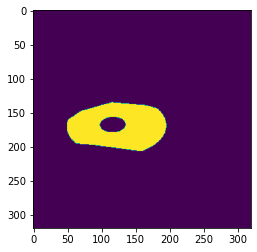

In [5]:
plt.imshow(lb[0, ..., 2])

In [6]:
testG.input_shape

(320, 320, 3)

In [7]:
model = build_FC_DenseNet10(
    # nb_classes=testG.num_classes, 
    nb_classes=4,
    final_softmax=True, 
    input_shape=testG.input_shape

)

modelpath = '../models/epoch_124_miou_0.9345.h5' # openeds weights
# modelpath = '/home/choppy/TOC/densenet10/models/weights/dense_models/blurry_gemini_dense_miou_0.9275.h5' # alcohol weights

model.load_weights(modelpath)

INFO:tensorflow:Layers in each dense block: [3, 3, 3, 3, 3, 3, 3, 3, 3]


2022-10-19 18:01:59.922386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 18:01:59.922756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-10-19 18:01:59.922821: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-19 18:01:59.922839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-19 18:01:59.922855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-19 18:01:59.922870: I tensorf

INFO:tensorflow:Number of skip connections: 4


# Model Info

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
f'{model.count_params():,}'

'210,732'

# Pred one image

2022-10-19 18:02:02.035466: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-19 18:02:02.732621: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-10-19 18:02:02.773755: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-19 18:02:03.742100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


((320, 320, 4), (1, 320, 320, 3))

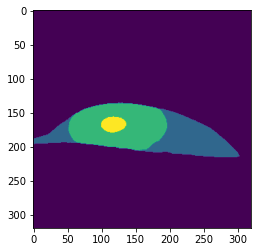

In [10]:
im, lb = testG[0]
pred = model.predict(im)[0]
plt.imshow(np.argmax(pred, axis=-1))
pred.shape, im.shape

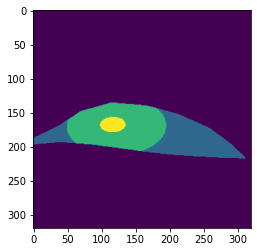

In [11]:
plt.imshow(np.argmax(lb[0, ...], axis=-1))

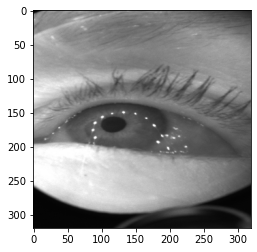

In [12]:
plt.imshow(im[0, ...])

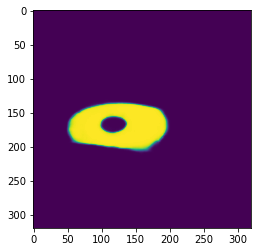

In [13]:
plt.imshow(pred[..., 2]) # choose between 0-1-2-3 classes

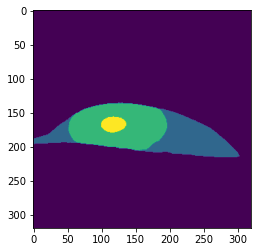

In [14]:
plt.imshow(np.argmax(pred, axis=-1)) # show all classes

# Evaluate final IoU of test set

In [15]:
val_iou = []

for i in tqdm(range(len(testG)), desc='test set'):
    fname = testG.image_info[i]['path']
    im, lb = testG[i]
    start = time.time()
    output_image = model.predict(im)[0]
    end = time.time()
    iou = mIoU(output_image, lb[0, ...])
    val_iou.append({
        'fname': fname,
        'miou': iou['miou'],
        'inf_time': end-start,
        '_classes': {
            'bg': iou['bg'],
            'iris': iou['iris'],
            'pupil': iou['pupil'],
            'sclera': iou['sclera']
        },
    })

miou = np.mean([elem['miou'] for elem in val_iou])
std_iou = np.std([elem['miou'] for elem in val_iou])
iou_bg = np.mean([elem['_classes']['bg'] for elem in val_iou])
iou_iris = np.mean([elem['_classes']['iris'] for elem in val_iou])
iou_pupil = np.mean([elem['_classes']['pupil'] for elem in val_iou])
iou_sclera = np.mean([elem['_classes']['sclera'] for elem in val_iou])

print(f'mean iou: {miou}')
print(f'std iou: {std_iou}')
print(f'miou bg: {iou_bg}')
print(f'miou iris: {iou_iris}')
print(f'miou pupil: {iou_pupil}')
print(f'miou sclera: {iou_sclera}')

test set:   6%|█████████▌                                                                                                                                                       | 135/2263 [00:16<04:07,  8.59it/s]/tmp/ipykernel_436/553149205.py:42: RuntimeWarning: invalid value encountered in float_scalars
  iou = np.mean(I[index] / U[index])
test set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2263/2263 [04:47<00:00,  7.88it/s]

mean iou: 0.9298775792121887
std iou: 0.05480319634079933
miou bg: 0.9911108016967773
miou iris: 0.9300795197486877
miou pupil: 0.9182388782501221
miou sclera: 0.8800812363624573
